# Migrating from MultiPromptChain

The [`MultiPromptChain`](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.router.multi_prompt.MultiPromptChain.html) routed an input query to one of multiple LLMChains-- that is, given an input query, it used a LLM to select from a list of prompts, formatted the query into the prompt, and generated a response.

`MultiPromptChain` does not support common [chat model](/docs/concepts/#chat-models) features, such as message roles and [tool calling](/docs/concepts/#functiontool-calling).

A [LangGraph](https://langchain-ai.github.io/langgraph/) implementation confers a number of advantages for this problem:

- Supports chat prompt templates, including messages with `system` and other roles;
- Supports the use of tool calling for the routing step;
- Supports streaming of both individual steps and output tokens.

Now let's look at them side-by-side. Note that for this guide we will `langchain-openai >= 0.1.20`

In [ ]:
%pip install -qU langchain-core langchain-openai

In [ ]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass()

## Legacy

<details open>

In [4]:
from langchain.chains.router.multi_prompt import MultiPromptChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

prompt_1_template = """
You are an expert on animals. Please answer the below query:

{input}
"""

prompt_2_template = """
You are an expert on vegetables. Please answer the below query:

{input}
"""

prompt_infos = [
    {
        "name": "animals",
        "description": "prompt for an animal expert",
        "prompt_template": prompt_1_template,
    },
    {
        "name": "vegetables",
        "description": "prompt for a vegetable expert",
        "prompt_template": prompt_2_template,
    },
]

chain = MultiPromptChain.from_prompts(llm, prompt_infos)

In [5]:
chain.invoke({"input": "What color are carrots?"})

{'input': 'What color are carrots?',
 'text': 'Carrots are most commonly orange, but they can also be found in a variety of other colors including purple, yellow, white, and red. The orange variety is the most popular and widely recognized.'}

In the [LangSmith trace](https://smith.langchain.com/public/e935238b-0b63-4984-abc8-873b2170a32d/r) we can see the two steps of this process, including the prompts for routing the query and the final selected prompt.

</details>

## LangGraph

<details open>

In [ ]:
pip install -qU langgraph

In [1]:
from operator import itemgetter
from typing import Literal

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict

llm = ChatOpenAI(model="gpt-4o-mini")

# Define the prompts we will route to
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on animals."),
        ("human", "{input}"),
    ]
)
prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert on vegetables."),
        ("human", "{input}"),
    ]
)

# Construct the chains we will route to. These format the input query
# into the respective prompt, run it through a chat model, and cast
# the result to a string.
chain_1 = prompt_1 | llm | StrOutputParser()
chain_2 = prompt_2 | llm | StrOutputParser()


# Next: define the chain that selects which branch to route to.
# Here we will take advantage of tool-calling features to force
# the output to select one of two desired branches.
route_system = "Route the user's query to either the animal or vegetable expert."
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", route_system),
        ("human", "{input}"),
    ]
)


# Define schema for output:
class RouteQuery(TypedDict):
    """Route query to destination expert."""

    destination: Literal["animal", "vegetable"]


route_chain = route_prompt | llm.with_structured_output(RouteQuery)


# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    query: str
    destination: RouteQuery
    answer: str


# We define functions for each node, including routing the query:
async def route_query(state: State, config: RunnableConfig):
    destination = await route_chain.ainvoke(state["query"], config)
    return {"destination": destination}


# And one node for each prompt
async def prompt_1(state: State, config: RunnableConfig):
    return {"answer": await chain_1.ainvoke(state["query"], config)}


async def prompt_2(state: State, config: RunnableConfig):
    return {"answer": await chain_2.ainvoke(state["query"], config)}


# We then define logic that selects the prompt based on the classification
def select_node(state: State) -> Literal["prompt_1", "prompt_2"]:
    if state["destination"] == "animal":
        return "prompt_1"
    else:
        return "prompt_2"


# Finally, assemble the multi-prompt chain. This is a sequence of two steps:
# 1) Select "animal" or "vegetable" via the route_chain, and collect the answer
# alongside the input query.
# 2) Route the input query to chain_1 or chain_2, based on the
# selection.
graph = StateGraph(State)
graph.add_node("route_query", route_query)
graph.add_node("prompt_1", prompt_1)
graph.add_node("prompt_2", prompt_2)

graph.add_edge(START, "route_query")
graph.add_conditional_edges("route_query", select_node)
graph.add_edge("prompt_1", END)
graph.add_edge("prompt_2", END)
app = graph.compile()

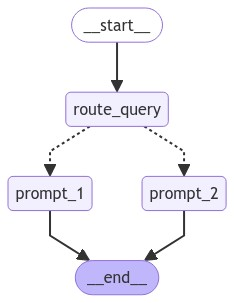

In [2]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

We can invoke the chain as follows:

In [3]:
state = await app.ainvoke({"query": "what color are carrots"})
print(state["destination"])
print(state["answer"])

{'destination': 'vegetable'}
Carrots are most commonly orange, but they can also come in a variety of other colors, including purple, red, yellow, and white. The different colors often indicate varying flavors and nutritional profiles. For example, purple carrots contain anthocyanins, while orange carrots are rich in beta-carotene, which is converted to vitamin A in the body.


In the [LangSmith trace](https://smith.langchain.com/public/1017a9d2-2d2a-4954-a5fd-5689632b4c5f/r) we can see the tool call that routed the query and the prompt that was selected to generate the answer.

</details>

## Overview:

- Under the hood, `MultiPromptChain` routed the query by instructing the LLM to generate JSON-formatted text, and parses out the intended destination. It took a registry of string prompt templates as input.
- The LangGraph implementation, implemented above via lower-level primitives, uses tool-calling to route to arbitrary chains. In this example, the chains include chat model templates and chat models.

## Next steps

See [this tutorial](/docs/tutorials/llm_chain) for more detail on building with prompt templates, LLMs, and output parsers.

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph.